<a href="https://colab.research.google.com/github/wafa-b/Introduction-to-Deep-Learning-with-PyTorch/blob/master/Study%20jam%20challenge/Style_Transfer_Submission_Prayers_Color_our_Life.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive/')

In [0]:
import os
os.chdir("/content/drive/My Drive/")

In [0]:
!pip install Pillow
!pip install PIL
!pip install image
import PIL

ERROR: Could not find a version that satisfies the requirement PIL (from versions: none)
ERROR: No matching distribution found for PIL


In [0]:
#Import Libraries
import torch
import numpy as np
import requests
import torch.optim as optim
from  torchvision import transforms,models
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
#Get features oprtion of VGG19
vgg=models.vgg19(pretrained=True).features
#Freeze all VGG paramwters since we are onle optimizing target image
for param in vgg.parameters():
    param.requires_grad_(False)

In [0]:
#Move model to GPU , If available
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [0]:
def load_image(img_path,max_size=100,shape=None):
    if "http" in img_path:
        response=requests.get(img_path)
        image=Image.open(BytesIO(response.content)).convert('RGB')
    else:
        image=Image.open(img_path).convert("RGB")
        
    #Large images will slow down processing
    if max(image.size)>max_size:
        size=max(image.size)
    else:
        size=max(image.size)
    
    if shape is not None:
        size=shape
        
    in_transform=transforms.Compose([transforms.Resize(size),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.485,0.456,0.406),
                                                        (0.229,0.224,0.225))])
    #Discard transparent,alpha channel and & batch dimension
    image=in_transform(image)[:3,:,:].unsqueeze(0)
    
    return image

In [0]:
#Load content image
content=load_image('images/mosque.jpg').to(device)
#Load style image & Resize it to match content
style=load_image('images/red sunset.jpg',shape=content.shape[-2:]).to(device)

In [0]:
#Helper function to un-normalizing image & converting it form Tensor image to NumPy image for display
def image_convert(tensor):
    image=tensor.to("cpu").clone().detach()
    image=image.numpy().squeeze()
    image=image.transpose(1,2,0)
    image=image*np.array((0.229,0.224,0.225))+np.array((0.485,0.456,0.406))
    image=image.clip(0,1)
    
    return image

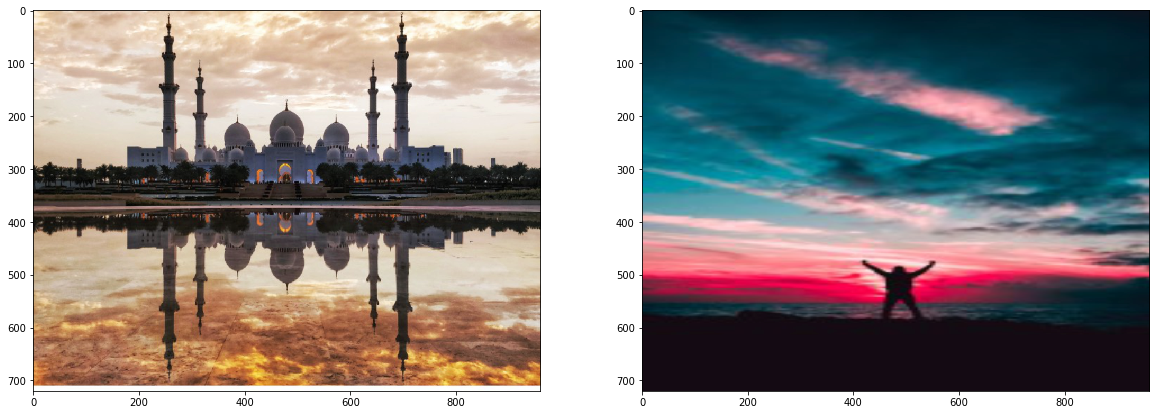

In [0]:
#Display imagesd
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
# display content image & style image side-by-side
ax1.imshow(image_convert(content))
ax2.imshow(image_convert(style))

In [0]:
# print out VGG19 structure so you can see the names of various layers
print(vgg)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [0]:
def get_features(image,model,layers=None):
    
    ## TODO: Complete mapping layer names of PyTorch's VGGNet to names from the paper
    ## Need the layers for the content and style representations of an image
    if layers is None:
        layers={'0':'conv1_1',
               '5':'conv2_1',
               '10':'conv3_1',
               '19':'conv4_1',
               '21':'conv4_2',
               '28':'conv5_1'}
    features={}
    x=image
    #model._modules is a dictionary holding each module in the model
    for name,layer in model._modules.items():
        x=layer(x)
        if name in layers:
            features[layers[name]]=x
            
    return features

In [0]:
def gram_matrix(tensor):
    #Get the batch_size, depth, height, and width of the Tensor
    _,d,h,w=tensor.size()
    #Reshape it, so we're multiplying the features for each channel
    tensor=tensor.view(d,h*w)
    #Calculate the gram matrix
    gram=torch.mm(tensor,tensor.t())
    
    return gram

In [0]:
#Get content and style features only once before training
content_features=get_features(content,vgg)
style_features=get_features(style,vgg)

#Calculate gram matrices for each layer of our style representation
style_grams={layer:gram_matrix(style_features[layer]) for layer in style_features}

#Create a third "target" image and prep it for change
#It is a good idea to start off with the target as a copy of our *content* image
#Then iteratively change its style
target=content.clone().requires_grad_(True).to(device)

In [0]:
#Weights for each style layer 
#Weighting earlier layers more will result in *larger* style artifacts
#Notice we are excluding `conv4_2` our content representation
style_weights={'conv1_1': 1.,
                 'conv2_1': 0.8,
                 'conv3_1': 0.5,
                 'conv4_1': 0.3,
                 'conv5_1': 0.1}
content_weight=1  # alpha
style_weight=1e6  # beta

Total loss:  87712216.0


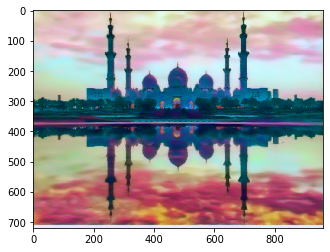

Total loss:  40657372.0


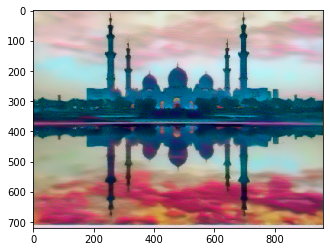

Total loss:  30885862.0


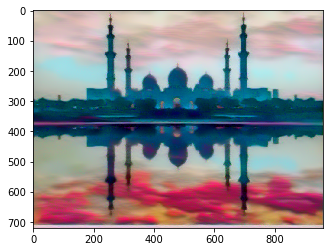

Total loss:  24543246.0


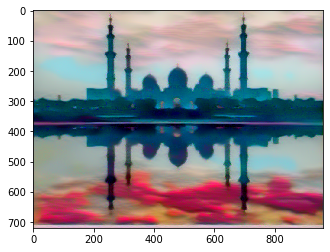

Total loss:  19643428.0


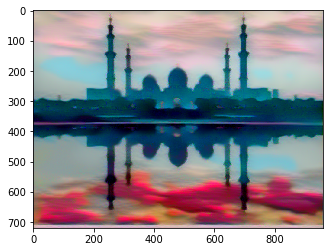

In [0]:
#To displaying the target image,intermittently
show_every=400

#Iteration hyperparameters
optimizer=optim.Adam([target],lr=0.003)
steps=2000  # decide how many iterations to update your image (5000)

for ii in range(1,steps+1):
    
    ##Get the features from your target image    
    target_features=get_features(target,vgg)
    ##Then calculate the content loss
    content_loss=torch.mean((target_features['conv4_2']-content_features['conv4_2']**2))
    
    #The style loss
    #Initialize the style loss to 0
    style_loss = 0
    #Iterate through each style layer and add to the style loss
    for layer in style_weights:
        #Get the "target" style representation for the layer
        target_feature=target_features[layer]
        _, d, h, w=target_feature.shape
        
        #Calculate target gram matrix
        target_gram=gram_matrix(target_feature)
        _,d,h,w=target_feature.shape
        
        #Get style representation
        style_gram=style_grams[layer]
        #Calculate the style loss for one layer, weighted appropriately
        layer_style_loss=style_weights[layer]*torch.mean((target_gram - style_gram)**2)

        #Add to the style loss
        style_loss+=layer_style_loss/(d*h*w)
        
        
    #Calculate total loss
    total_loss=content_weight*content_loss+style_weight*style_loss

        #Update your target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    #Display intermediate images and print the loss
    if  ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(image_convert(target))
        plt.show()

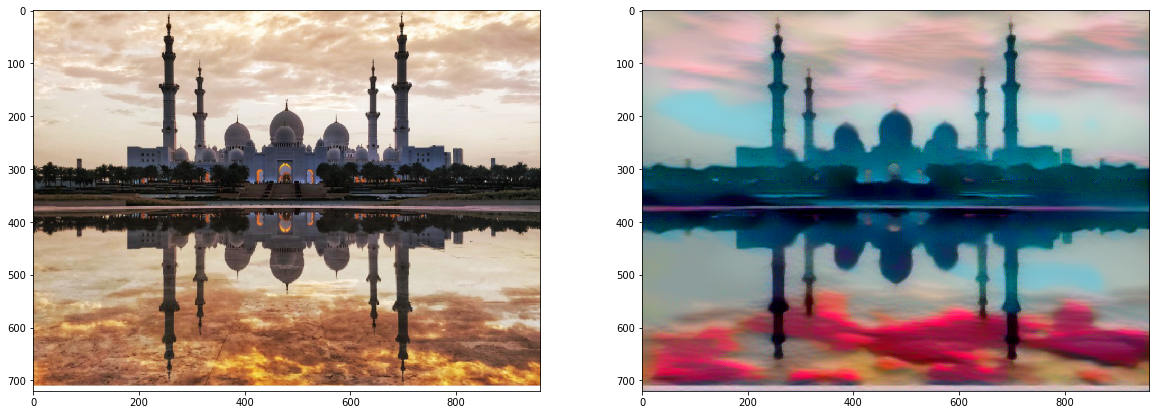

In [0]:
#Display content & final target image
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
ax1.imshow(image_convert(content))
ax2.imshow(image_convert(target))